In [1]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

SRC_PATH = os.path.abspath(os.path.join('../..'))
sys.path.append(SRC_PATH)

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import models
from prflwr.utils.pytorch import set_seed
from torch.utils.data import DataLoader

from utils import load_data, load_model, test, train

SEED = 0
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)
print("numpy", np.__version__)
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print(f"Training on {DEVICE}")


numpy 1.20.3
torch 1.11.0
torchvision 0.12.0
Training on cuda


In [2]:
# Load data
trainset, testset = load_data("../..")
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


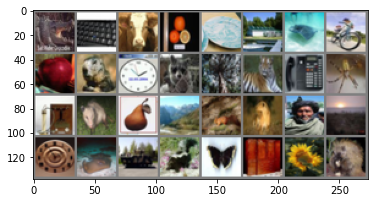

crocodile - keyboard - cattle - orange - plate - house -   ray - bicycle - 
apple - beaver - clock - raccoon - pine_tree - tiger - telephone - spider - 
telephone - possum -  pear - mountain - squirrel -  lion -   man - plain - 
clock -   ray -  tank - skunk - butterfly - wardrobe - sunflower - porcupine - 



In [3]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

images, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(images))
print(''.join('%5s - ' % trainset.classes[labels[j]].replace(" ", "") + ("\n" if (j + 1) % 8 == 0 else "") for j in range(32)))

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
import utils
from importlib import reload
reload(utils)
from utils import train

In [74]:
# Load model
model = models.resnet18(pretrained=False, num_classes=100)
print("Number of parameters:", count_parameters(model))

Number of parameters: 11227812


In [75]:
from torch.optim.lr_scheduler import _LRScheduler
class WarmUpLR(_LRScheduler):
    """warmup_training learning rate scheduler
    Args:
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """
    def __init__(self, optimizer, total_iters, last_epoch=-1):
        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """we will use the first m batches, and set the learning
        rate to base_lr * m / total_iters
        """
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

In [76]:
EPOCHS = 1
MILESTONES = [60, 120, 160]
WARMUP_EPOCHS = 10

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
train_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.2)  #learning rate decay
iter_per_epoch = len(trainset)
warmup_scheduler = WarmUpLR(optimizer, WARMUP_EPOCHS)

In [77]:
# Check initial evaluation metrics
loss, accuracy = test(model, testloader, device=DEVICE)
print(f"Initial test set performance: loss {loss}, accuracy {accuracy}")

Initial test set performance: loss 4.6149784912109375, accuracy 0.0088


In [78]:
# Start centralized training
for epoch in range(EPOCHS):
    train(model, trainloader, optimizer=optimizer, device=DEVICE)
    loss, accuracy = test(model, testloader, device=DEVICE)
    if epoch < WARMUP_EPOCHS:
        warmup_scheduler.step()
    else:
        train_scheduler.step(epoch)
    print(f"Epoch {epoch+1}: test loss {loss}, accuracy {accuracy}, learning rate {optimizer.param_groups[0]['lr']}")

KeyboardInterrupt: 

In [ ]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)

In [ ]:
# Evaluate performances on testset
loss, accuracy = test(model, testloader, device=DEVICE)
print(f"Final test set performance: loss {loss}, accuracy {accuracy}")

Final test set performance: loss 4.003739193725586, accuracy 0.078
